# Step 1: Basic Evaluation
In our first step, we will be covering how we can perform basic evaluation. One of the great parts of FiftyOne is that once your data and model predictions are in FiftyOne, evaluation becomes easy, no matter if you are coming from different formats. Gone are the days of converting your YOLO styled predictions to COCO styled evaluation, FiftyOne handles all the conversions for you so you can focus on the task at hand.

Let's take a look first at loading a common a dataset with predictions.

### Installation

Here are some packages that are needed to help run some of our demo code:

In [ ]:
pip install torch ultralytics pycocotools

## Loading a Zoo Dataset for Evaluation
We will be loading the `quickstart`[LINK] dataset from the Dataset Zoo[LINK]. This dataset is a slice of MSCOCO and contains some preloaded predictions. If you are unsure how to load your own detection dataset, be sure to checkout our Getting Started with Detections [LINK]

Once our dataset is loaded, we can start getting ready for model eval!

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("quickstart")

# View summary info about the dataset
print(dataset)

Dataset already downloaded
Loading existing dataset 'quickstart'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Name:        quickstart
Media type:  image
Num samples: 200
Persistent:  False
Tags:        []
Sample fields:
    id:                fiftyone.core.fields.ObjectIdField
    filepath:          fiftyone.core.fields.StringField
    tags:              fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:        fiftyone.core.fields.DateTimeField
    last_modified_at:  fiftyone.core.fields.DateTimeField
    ground_truth:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    uniqueness:        fiftyone.core.fields.FloatField
    predictions:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    eval_tp:           fiftyone.core.fields.IntFiel

Before we go further, let’s launch the FiftyOne App [LINK] and use the GUI to explore the dataset visually:

In [2]:
session = fo.launch_app(dataset, auto=False)

Session launched. Run `session.show()` to open the App in a cell output.


## Evaluate Detections

Now that we have samples with ground truth and predicted objects, let’s use FiftyOne to evaluate the quality of the detections.

FiftyOne provides a powerful evaluation API [LINK] that contains a collection of methods for performing evaluation of model predictions. Since we’re working with object detections here, we’ll use detection evaluation [LINK]

We can run evaluation on our samples via `evaluate_detections()` [LINK]. Note that this method is available on both the `Dataset` and `DatasetView` classes, which means that we can run evaluation on subsets of our dataset as well.

By default, this method will use the COCO evaluation protocol, plus some extra goodies that we will use later.

In [3]:
results = dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)

Evaluating detections...
 100% |█████████████████| 200/200 [7.5s elapsed, 0s remaining, 18.3 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 200/200 [2.4s elapsed, 0s remaining, 76.0 samples/s]       


## Analyzing Results

The `results` object returned by the evaluation routine provides a number of convenient methods for analyzing our predictions.

For example, let’s print a classification report for the top-10 most common classes in the dataset:

In [4]:
# Get the 10 most common classes in the dataset
counts = dataset.count_values("ground_truth.detections.label")
classes_top10 = sorted(counts, key=counts.get, reverse=True)[:10]

# Print a classification report for the top-10 classes
results.print_report(classes=classes_top10)

               precision    recall  f1-score   support

       person       0.52      0.94      0.67       716
         kite       0.59      0.88      0.71       140
          car       0.18      0.80      0.29        61
         bird       0.65      0.78      0.71       110
       carrot       0.09      0.74      0.16        47
         boat       0.09      0.46      0.16        37
    surfboard       0.17      0.73      0.28        30
traffic light       0.32      0.79      0.45        24
     airplane       0.36      0.83      0.50        24
        bench       0.17      0.52      0.26        23

    micro avg       0.38      0.87      0.53      1212
    macro avg       0.31      0.75      0.42      1212
 weighted avg       0.47      0.87      0.60      1212



We can also grab the mean average-precision (mAP) of our model as well:

In [5]:
print(results.mAP())

0.3957238101325776


## Evaluate Subsets

As mentioned before, we can evaluate `DatasetViews` as well! Let's evaluate only where our model is highly confident. First we will create a high confidence view, then evaluate with `evaluate_detections()` again. See using Dataset Views [LINK] for full details on matching, filtering, or sorting detections.  

In [6]:
from fiftyone import ViewField as F

# Only contains detections with confidence >= 0.75
high_conf_view = dataset.filter_labels("predictions", F("confidence") > 0.75, only_matches=False)

# Print some information about the view
print(high_conf_view)

Dataset:     quickstart
Media type:  image
Num samples: 200
Sample fields:
    id:                fiftyone.core.fields.ObjectIdField
    filepath:          fiftyone.core.fields.StringField
    tags:              fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:        fiftyone.core.fields.DateTimeField
    last_modified_at:  fiftyone.core.fields.DateTimeField
    ground_truth:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    uniqueness:        fiftyone.core.fields.FloatField
    predictions:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    eval_high_conf_tp: fiftyone.core.fields.IntField
    eval_high_conf_fp: fiftyone.core.fields.IntField
    eval_high_conf_fn: fiftyone.core.fields.IntField
    eval_tp:           fiftyone.core.fields.IntField
    eval_fp:           fiftyone.core.f

We can check out our new view in the session before we run evaluation:

In [7]:
session.view = high_conf_view

Just like before, lets run evaluation. Be sure to change the eval_key to a new name this time!

In [8]:
results = high_conf_view.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval_high_conf",
    compute_mAP=True,
)

# Print the same report to see the difference
results.print_report(classes=classes_top10)
print(results.mAP())

Evaluating detections...
 100% |█████████████████| 200/200 [1.4s elapsed, 0s remaining, 113.3 samples/s]         
Performing IoU sweep...
 100% |█████████████████| 200/200 [920.9ms elapsed, 0s remaining, 217.2 samples/s]      
               precision    recall  f1-score   support

       person       0.85      0.72      0.78       412
         kite       0.84      0.68      0.75        91
          car       0.74      0.51      0.60        61
         bird       0.91      0.48      0.63        64
       carrot       0.58      0.40      0.47        47
         boat       0.62      0.35      0.45        37
    surfboard       0.63      0.40      0.49        30
traffic light       0.88      0.62      0.73        24
     airplane       0.90      0.79      0.84        24
        bench       0.88      0.30      0.45        23

    micro avg       0.82      0.62      0.70       813
    macro avg       0.78      0.53      0.62       813
 weighted avg       0.81      0.62      0.70       813



## Evaluate for Classification

Evaluation is just as easy for classification tasks. Once you have loaded up your dataset and model predictions, you can start with `dataset.evaluate_classifications()`

If you need a refresher on how to work with classification datasets, head over to Getting Started with Classifications! [LINK]

Split 'test' already downloaded
Loading existing dataset 'cifar10-test'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use



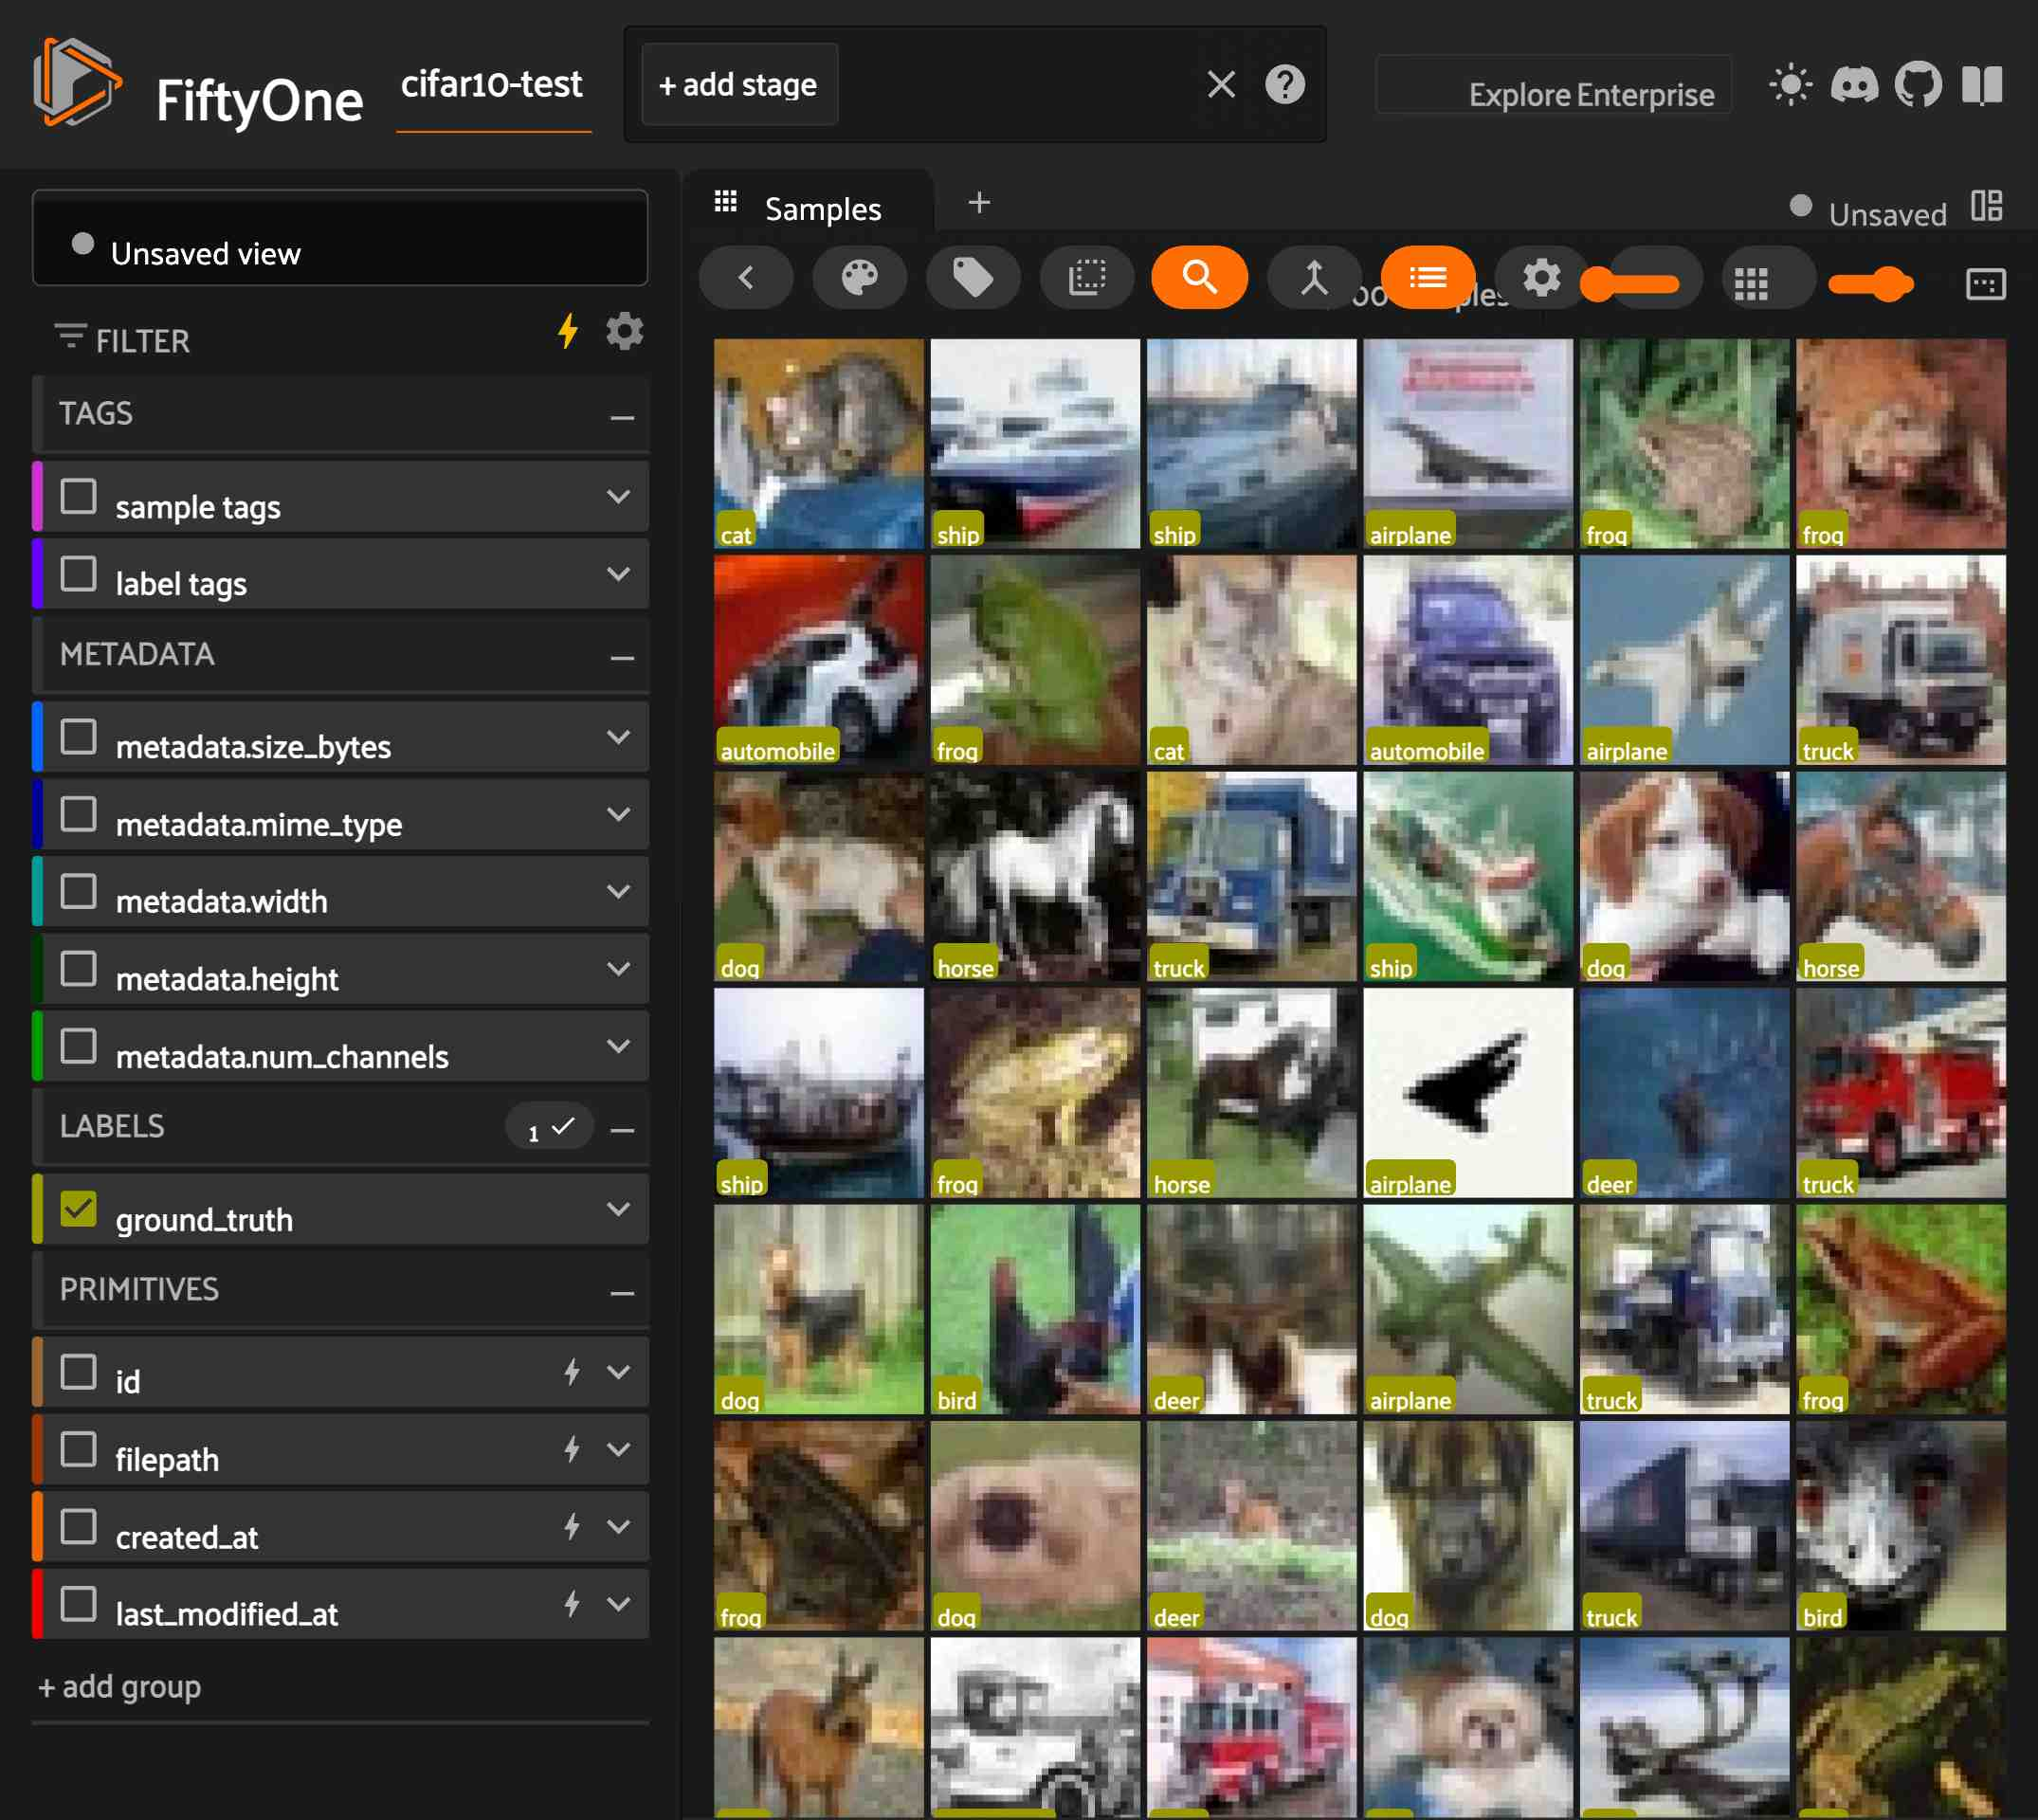


Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.4.0

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("cifar10", split="test")

session = fo.launch_app(dataset)

In [5]:
import fiftyone.zoo as foz

classes = ["horse", "truck", "deer", "automobile", "bird", "ship", "cat", "dog", "frog", "airplane"]

clip = foz.load_zoo_model(
    "clip-vit-base32-torch",
    classes=classes,
)

first_5_samples = dataset.limit(5)

first_5_samples.apply_model(clip, label_field="clip")

results = first_5_samples.evaluate_classifications("clip")

# Print the same report to see the difference
results.print_report()

 100% |█████████████████████| 5/5 [106.4ms elapsed, 0s remaining, 47.0 samples/s]     
              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00         1
        bird       0.00      0.00      0.00         0
         cat       1.00      1.00      1.00         1
        frog       1.00      1.00      1.00         1
        ship       1.00      1.00      1.00         2

    accuracy                           0.80         5
   macro avg       0.60      0.60      0.60         5
weighted avg       0.80      0.80      0.80         5



## Evaluate for Segmentation

The last basic form of evaluation we will cover is evaluating segmentations! 

There are two popular forms of segmentations, Instance Segmentation [LINK] and Semantic Segmentation[LINK]. In FiftyOne, instance segmentation is stored in `fo.Detections` [LINK] and semantic segmentations are stored in `fo.Segmentations`. We will cover how to evaluate both.

If you need a refresher on how to work with segmentation datasets, head over to Getting Started with Segmentations! [LINK]

Once your dataset is prepped and ready with ground_truth and predicted segmentations, you can start evaluation!

### Instance Segmentation Example

Found annotations at '/Users/dangural/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation-25'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use



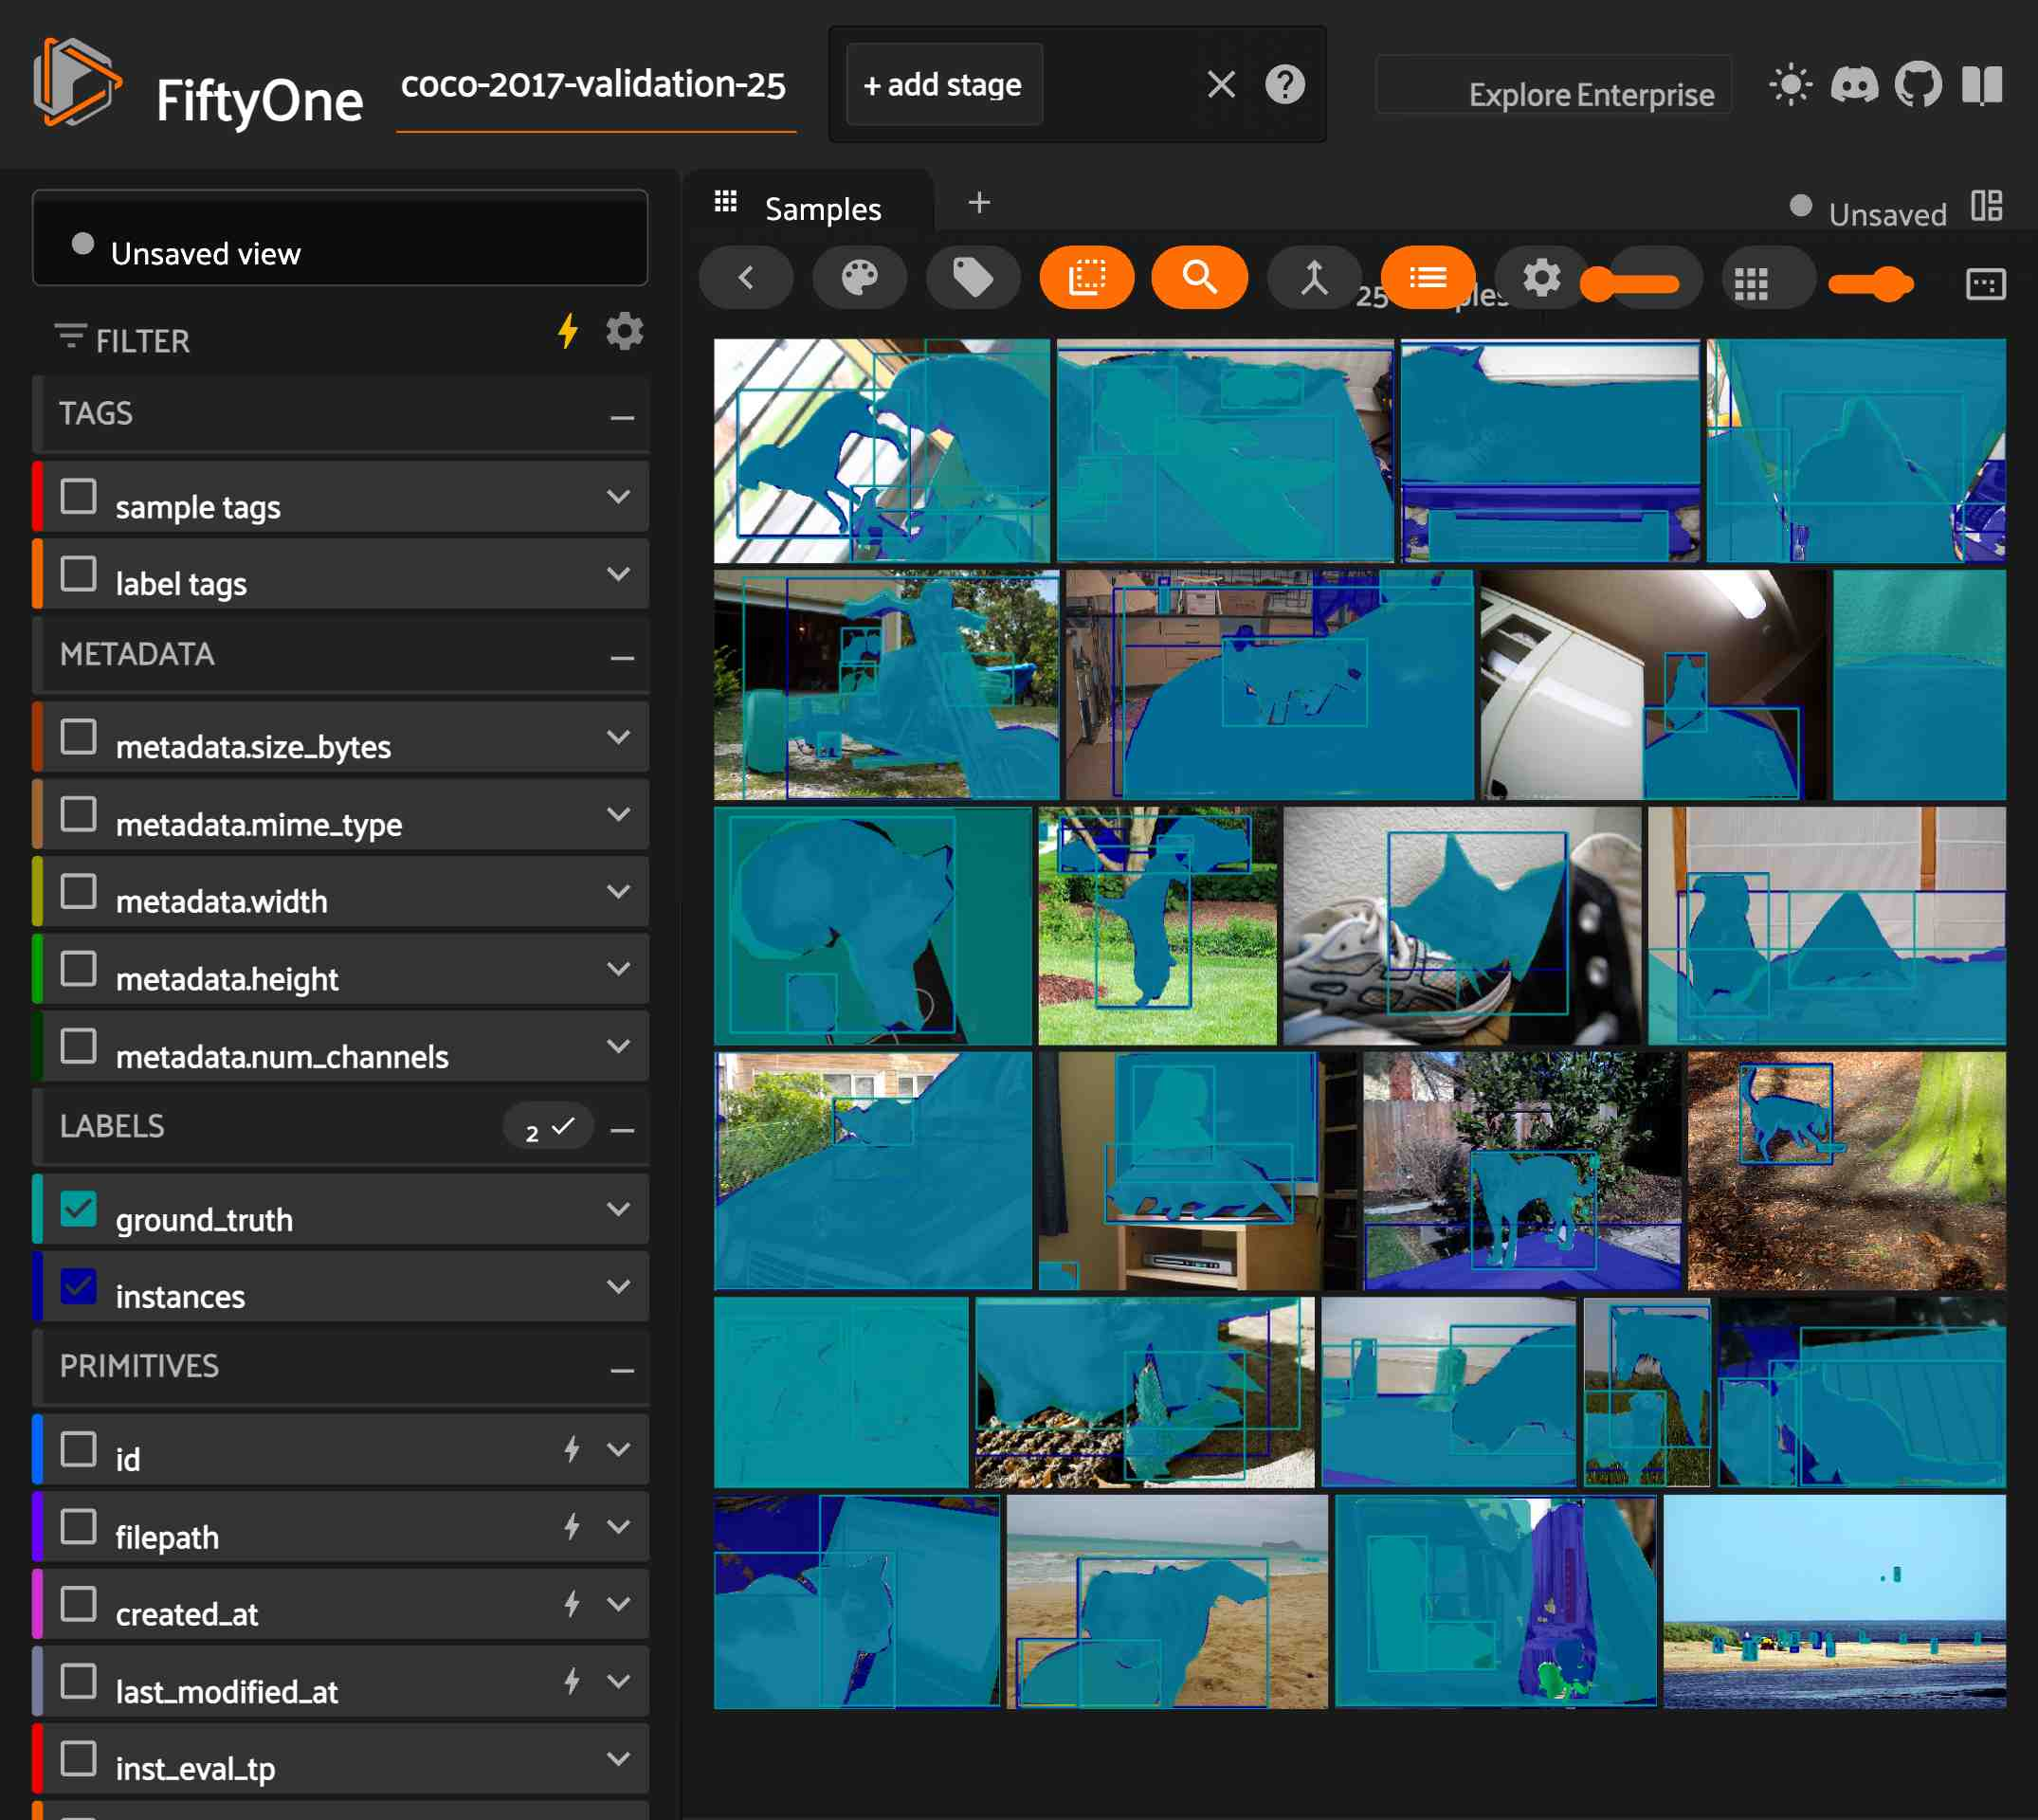

In [ ]:
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["segmentations"],
    classes=["cat", "dog"],
    max_samples=25,
)

session.dataset = dataset

100%|██████████| 19.7M/19.7M [00:02<00:00, 7.54MB/s]


 100% |███████████████████| 25/25 [3.2s elapsed, 0s remaining, 8.2 samples/s]      



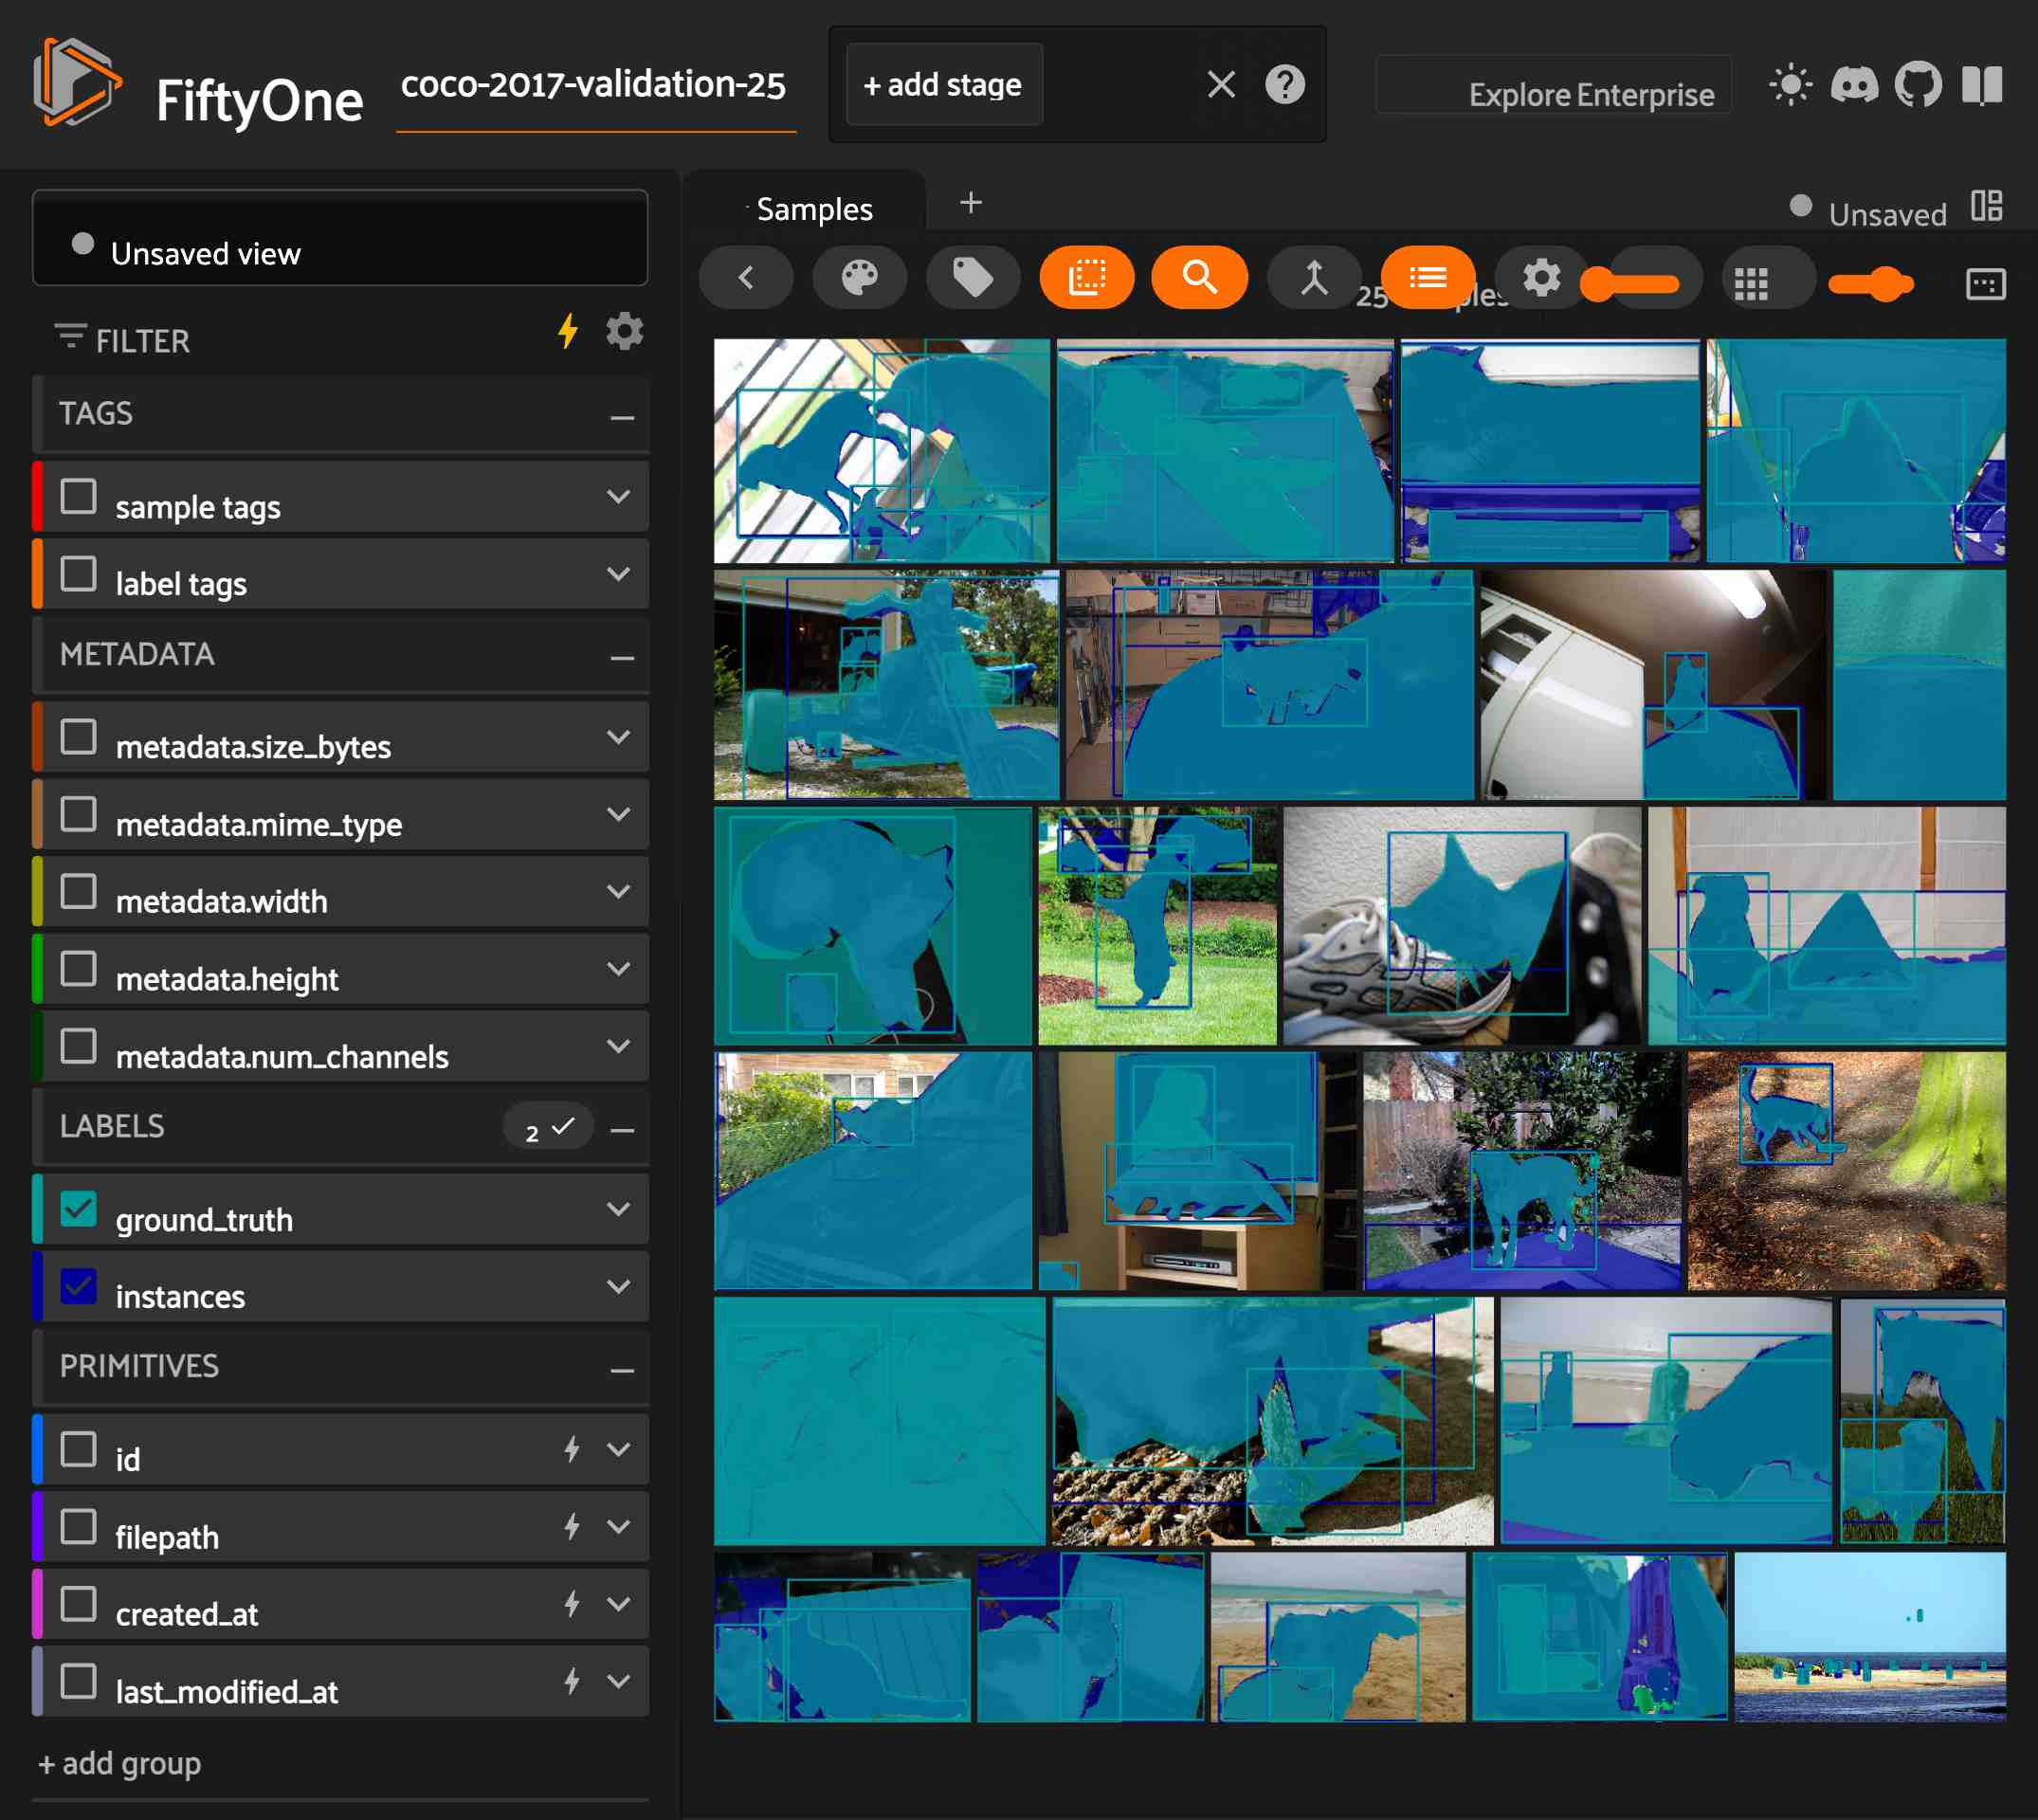

In [ ]:
from ultralytics import YOLO

# Use the YOLO model to add some predictions to the dataset
model = YOLO("yolo11s-seg.pt")

dataset.apply_model(model, label_field="instances")

With our model and predictions loaded, lets run evaluation with `detection.evaluate_detection()` [LINK].

In [13]:
results = dataset.evaluate_detections(
    "instances",
    gt_field="ground_truth",
    eval_key="inst_eval",
    use_masks=True,
    compute_mAP=True,
)

# Print the same report to see the difference
results.print_report()
print(results.mAP())

Evaluating detections...
 100% |███████████████████| 25/25 [240.5ms elapsed, 0s remaining, 104.0 samples/s]      
Performing IoU sweep...
 100% |███████████████████| 25/25 [154.1ms elapsed, 0s remaining, 162.3 samples/s]     
              precision    recall  f1-score   support

         bed       1.00      0.50      0.67         4
       bench       0.50      1.00      0.67         1
     bicycle       0.67      0.67      0.67         3
        bird       0.00      0.00      0.00         1
        book       0.67      1.00      0.80         2
      bottle       1.00      1.00      1.00         2
        bowl       1.00      1.00      1.00         1
         car       0.50      1.00      0.67         4
         cat       1.00      1.00      1.00        18
  cell phone       0.00      0.00      0.00         0
       chair       0.00      0.00      0.00         1
       couch       0.50      0.50      0.50         2
         cup       1.00      1.00      1.00         1
dining table     

### Semantic Segmentation Evaluation

Now let's look at an example of semantic segmentation. We can easily convert our instance segmentation dataset to semantic masks using `to_segmentation()` [LINK]. After we convert our `ground_truth` and `instances` fields, we can evaluate our new masks! Let's convert now:

In [ ]:
dataset.compute_metadata()
for sample in dataset:

    detections = sample["ground_truth"]
    segmentation = detections.to_segmentation(
        frame_size=(sample.metadata.width, sample.metadata.height),
        mask_targets={1: "cat", 2: "dog"},
    )
    sample["gt_semantic"] = segmentation

    detections = sample["instances"]
    segmentation = detections.to_segmentation(
        frame_size=(sample.metadata.width, sample.metadata.height),
        mask_targets={1: "cat", 2: "dog"},
    )
    sample["pred_semantic"] = segmentation
    sample.save()

session.show()

Finally, we can evaluate our semantic segmentations with `dataset.evaluate_segmentations()`:

In [9]:
results = dataset.evaluate_segmentations("gt_semantic", "pred_semantic", eval_key="seg_eval")
results.print_report()

Computing possible mask values...
 100% |███████████████████| 25/25 [274.0ms elapsed, 0s remaining, 91.2 samples/s]      
Evaluating segmentations...
 100% |███████████████████| 25/25 [207.0ms elapsed, 0s remaining, 120.7 samples/s]      
              precision    recall  f1-score   support

           1       0.90      0.96      0.93 1088297.0
           2       0.91      0.79      0.85  330667.0

   micro avg       0.90      0.92      0.91 1418964.0
   macro avg       0.91      0.88      0.89 1418964.0
weighted avg       0.90      0.92      0.91 1418964.0



## Conclusion

This covers the basic of model eval in FiftyOne. In the next step, we will learn how to dive even deeper with the Model Evaluation Panel [LINK], a interactive tool that allows you find exactly where your model is doing the best and the worst all in the FiftyOne app. Learn more by continuing!